# NLP для классификации твитов во время кризисных событий

- **Цел**ь. Подготовить твиты к дальнейшему моделированию и собрать baseline для задачи бинарной классификации **Related & informative vs Not informative** по тематике кризисов.

- **Предобработка текста**. Детект языка и перевод только уникальных текстов на английский с кэшированием в CSV; нормализация токенов: **URL**, **USER**, **HASHTAG**; демоджинг эмодзи и маппинг смайликов; удаление дубликатов по нормализованному тексту. Это ускоряет перевод и делает признаки стабильнее.

- **EDA и разбиение**. Быстрые проверки пропусков/распределений; стратифицированный **train/test-сплит** (и по всему датасету, и по каждой кризисной категории).

- **Baseline-модель**. Простое лексиконное правило на основе **CrisisLex** (по сути keyword-matching/regex); метрики: **accuracy**, **precision**, **recall**, **F1**, **ROC-AUC** + **матрица ошибок** и отчёт **classification_report**. Результаты служат нижней планкой (по категориям F1 колеблется, в среднем невысокий уровень).

- **Стек и инструменты**. Python, pandas, numpy, scikit-learn (metrics, split), regex, emoji, langdetect, deep-translator, tqdm, matplotlib/seaborn для графиков, MLflow (локальный трекинг) для логирования параметров/графиков и повторяемости экспериментов.

- **Выходы ноутбука**. 1) Очищенный столбец tweettext_proc; 2) кэш перевода/обработки; 3) готовые train/test CSV (для использования в следующих ноутбуках с LSTM/BERT/XLNet); 4) базовые метрики по лексиконной модели как точка отсчёта.


## Постановка задачи

Сбор и быстрый анализ данных во время чрезвычайных ситуаций критически важны: социальные сети дают наблюдения в реальном времени, но вместе с этим — много шума. Командам реагирования нужно как можно раньше распознавать сообщения, которые могут быть полезны для координации помощи и оценки последствий.

В этом проекте мы предлагаем анализировать кризисные события через призму методов NLP и учиться на исторических данных, чтобы иметь возможность применить полученные модели во время новых (ещё развивающихся) событий...

Конкретнее, мы ответим на следующие вопросы:

**Эффективность модели на реальных событиях того же типа**: если мы обучим сеть на архивных данных одного типа катастрофы (например, землетрясения), как она будет работать на новом землетрясении в реальном времени и сколько размеченных данных придётся добавить, чтобы дообучить модель под конкретное событие?

**Эффективность модели на событиях другого типа**: будет ли модель, обученная на одном типе катастроф (например, на наводнениях), работать на другом типе (например, на сходе поезда), или для переноса потребуются дополнительные данные и адаптация?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Набор данных

Изначальные данные содержат ~250 000 твитов на множестве языков. Мы используем поднаборы с разметкой уровня твита (информативность) и метаданными события: источник информации, тип информации и пр. Для воспроизводимости используем предоставленные организаторами наборы CrisisLex/CrisisNLP; далее все тексты приводятся к английскому (машинный перевод) и очищаются.

In [ ]:
!pip install langdetect
!pip install emoji
!pip install sentencepiece
!pip install transformers
!pip -q install deep-translator==1.11.4 langdetect==1.0.9
!pip -q install tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import nltk
from nltk.corpus import stopwords
import gc
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import ParameterSampler
import re
from langdetect import detect, LangDetectException
import emoji
from transformers import XLNetModel, XLNetTokenizer
from scipy.stats import loguniform
import json
import csv
from tqdm.auto import tqdm
import zipfile

In [ ]:
dir_path = '/content/drive/MyDrive/'
os.chdir(dir_path)

In [ ]:
with zipfile.ZipFile('CrisisLexT26-v1.0.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/drive/MyDrive/')

Загрузка данных:

In [ ]:
ncrisis = -1
df_total = []
for dirname, _, filenames in os.walk("/content/drive/MyDrive/CrisisLexT26"):
    df =  []
    tmp_csv = []
    tmp_json = []
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        print(fullpath)
        try:
            if fullpath.endswith('_labeled.csv'):
                tmp_csv = pd.read_csv(fullpath)
            elif fullpath.endswith('.json'):
                with open(fullpath) as f:
                    data = json.load(f)
                tmp_json = pd.json_normalize(data)
        except:
            print(fullpath)
            print('Exception error')
    if len(tmp_csv) >1:
        ncrisis  += 1
        tmp_json = pd.DataFrame(np.repeat(tmp_json.values, len(tmp_csv), axis=0), columns=tmp_json.columns)
        df = pd.concat([tmp_json, tmp_csv], axis=1)
        if ncrisis  == 0:
            df_total = df
        else:
             df_total = pd.concat([df_total, df], axis=0)

/content/drive/MyDrive/CrisisLexT26/.DS_Store
/content/drive/MyDrive/CrisisLexT26/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-event_description.json
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweetids_entire_period.csv
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-event_description.json
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-tweetids_entire_period.csv
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-tweets_labeled.csv
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Guatemala_earthquake/2012_Guatemala_earthquake-event_description

In [ ]:
formatted_columns = [col.lower().replace(" ", "").replace(".", "_") for col in df_total.columns]
df_total = pd.DataFrame(df_total.values, columns=formatted_columns)
df_total.columns

Index(['name', 'external_url', 'keywords', 'size_kw_collection',
       'size_geo_collection', 'time_development', 'time_duration', 'time_year',
       'time_month', 'time_start_day', 'location_country', 'location_spread',
       'location_location_description',
       'location_country_internet_penetration', 'categorization_category',
       'categorization_sub_category', 'categorization_type', 'tweetid',
       'tweettext', 'informationsource', 'informationtype', 'informativeness'],
      dtype='object')

In [ ]:
df_total.head(3)

,name,external_url,keywords,size_kw_collection,size_geo_collection,time_development,time_duration,time_year,time_month,time_start_day,...,location_location_description,location_country_internet_penetration,categorization_category,categorization_sub_category,categorization_type,tweetid,tweettext,informationsource,informationtype,informativeness
0,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related
1,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related
2,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related


# Предобработка твитов

- Перевод неанглийских твитов

In [ ]:
translator_global = GoogleTranslator(source='auto', target='en')
tqdm.pandas(desc="Translating tweets")

def translate_tweets(text):
    language = detect(text)
    if language != 'en':
        return translator_global.translate(text)
    return text

def transform_tweets(df_total):
    fullpath = os.path.join(dir_path, 'processed_v3.csv')

    if os.path.exists(fullpath):
        print(fullpath)
        tmp = pd.read_csv(fullpath, lineterminator='\n')
        tmp = tmp.rename(columns={'Tweet ID': 'tweetid', 'Processed': 'tweettext_proc'})
        tmp['tweetid'] = tmp['tweetid'].astype(int)
        df_total['tweetid'] = df_total['tweetid'].astype(int)
        df_total = pd.merge(df_total, tmp[['tweetid','tweettext_proc']], on='tweetid', how='left')
        df_total['tweettext_proc'] = df_total['tweettext_proc'].astype(str)

    else:
        texts = df_total['tweettext'].astype(str)
        uniq  = texts.unique()
        print(f'Unique texts to translate: {len(uniq)}')

        mapping = {}
        for t in tqdm(uniq, desc='Translating unique tweets'):
            mapping[t] = translate_tweets(t)

        df_total['tweettext_proc'] = texts.map(mapping)

        df_total[['tweetid','tweettext_proc']].to_csv(fullpath, index=False)

    return df_total

- замена всех URL на `<URL>`, хэштегов на `<HASHTAG>`, упоминаний пользователей на `<USER>`, смайликов на `<EMOTICON>` и эмодзи на `<EMOJI>`

In [ ]:
def replace_url(text):
    url_pattern = r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
    tweets = re.sub(url_pattern ,'<URL>', str(text))
    return tweets

def replace_hashtag(text):
    hashtag_pattern = r'#'
    tweets = re.sub(hashtag_pattern, '<HASHTAG>', str(text))
    return tweets

def replace_user(text):
    user_pattern = r'@\S+'
    tweets = re.sub(user_pattern, '<USER>', str(text))
    return tweets

def replace_emoticons(text):
    dict_emoticon = {":-)":"smiley", ":)":"smiley", "^^":"smiley", "=)":"smiley", ":]":"smiley",
                     ":>":"smiley", ":c)":"smiley", "x)":"smiley",":o)":"smiley", ";-)":"smiley",
                     ";)":"smiley", ";]":"smiley", ";o)":"smiley", ":-P":"smiley", ":b":"smiley",
                     ":p":"smiley", "=P":"smiley", ":P":"smiley", "xP":"smiley", ";-P":"smiley",
                     ":oP":"smiley", ":-D":"smiley", ";D":"smiley", ":D":"smiley", "=D":"smiley",
                     "xD":"smiley", "XD":"smiley", ":oD":"smiley", ":-0":"smiley", ":-o":"smiley",
                     ":o":"smiley", ":O":"smiley", "=O":"smiley", ":0":"smiley", "=o":"smiley",
                       ":‑(":"sad", ":(":"sad","=(":"sad", ":[":"sad",":<":"sad",":/":"sad",
                       "x(":"sad",":o(":"sad",":C":"sad",":'(":"sad",";(":"sad",
                       }


    words = text.split()
    reformed = [dict_emoticon[word] if word in dict_emoticon else word for word in words]
    tweet = " ".join(reformed)
    return tweet


def replace_emoji(text):
    tweets = emoji.demojize(text)
    tweets = tweets.replace(":"," ")
    tweets = ' '.join(tweets.split())
    return tweets

In [ ]:
df_total = transform_tweets(df_total)
df_total['tweettext_proc'] = df_total['tweettext_proc'].progress_apply(replace_url)
df_total['tweettext_proc'] = df_total['tweettext_proc'].progress_apply(replace_hashtag)
df_total['tweettext_proc'] = df_total['tweettext_proc'].progress_apply(replace_user)
df_total['tweettext_proc'] = df_total['tweettext_proc'].progress_apply(replace_emoticons)
df_total['tweettext_proc'] = df_total['tweettext_proc'].progress_apply(replace_emoji)
df_total = df_total.drop_duplicates(subset=['tweettext_proc'], keep='last')

/content/drive/MyDrive/processed_v3.csv


Translating tweets:   0%|          | 0/27935 [00:00<?, ?it/s]

Translating tweets:   0%|          | 0/27935 [00:00<?, ?it/s]

Translating tweets:   0%|          | 0/27935 [00:00<?, ?it/s]

Translating tweets:   0%|          | 0/27935 [00:00<?, ?it/s]

Translating tweets:   0%|          | 0/27935 [00:00<?, ?it/s]

In [ ]:
df_total.describe()

,tweetid
count,2.479400e+04
mean,3.247373e+17
std,6.313849e+16
min,2.034409e+17
25%,2.755397e+17
50%,3.296812e+17
75%,3.899226e+17
max,4.180546e+17


In [ ]:
df_total['cat_informativeness'] = df_total['informativeness']
df_total.loc[df_total.cat_informativeness != 'Related and informative','cat_informativeness'] = 'Not informative'

In [ ]:
df_total.groupby(['name', 'time_year', 'location_country', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
name                         time_year location_country cat_informativeness               
Alberta Floods               2013      Canada           Not informative                300
                                                        Related and informative        663
Australia wildfires          2013      Australia        Not informative                402
                                                        Related and informative        649
Bohol earthquake             2013      Phillipines      Not informative                463
                                                        Related and informative        374
Boston Bombings              2013      US               Not informative                555
                                                        Related and informative        398
Brazil nightclub fire        2013      Brazil           Not informative                401
                                                        Related and informative        393
Colorado Floods              2013      US               Not informative                205
                                                        Related and informative        735
Colorado wildfires           2012      US               Not informative                495
                                                        Related and informative        665
Costa Rica earthquake        2012      Costa Rica       Not informative                637
                                                        Related and informative        608
Glasgow helicopter crash     2013      UK               Not informative                408
                                                        Related and informative        477
Guatemala earthquake         2012      Guatemala        Not informative                261
                                                        Related and informative        667
Italy earthquakes            2012      Italy            Not informative                340
                                                        Related and informative        581
LA Airport Shootings         2013      US               Not informative                314
                                                        Related and informative        617
Lac-Megantic train crash     2013      Canada           Not informative                430
                                                        Related and informative        527
Manila Floods                2013      Phillipines      Not informative                346
                                                        Related and informative        562
NYC train crash              2013      US               Not informative                 89
                                                        Related and informative        684
Philipinnes Floods           2012      Philipinnes      Not informative                177
                                                        Related and informative        658
Queensland Floods            2013      Australia        Not informative                463
                                                        Related and informative        682
Russian meteor               2013      Russia           Not informative                709
                                                        Related and informative        525
Sardinia Floods              2013      Italy            Not informative                341
                                                        Related and informative        533
Savar building collapse      2013      Bangladesh       Not informative                388
                                                        Related and informative        742
Singapore Haze               2013      Singapore        Not informative                421
                                                        Related and informative        351
Spain train crash            2013      Spain            Not informative      

In [ ]:
df_total.groupby(['categorization_type', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
categorization_type cat_informativeness               
Bombings            Not informative                555
                    Related and informative        398
Collapse            Not informative                388
                    Related and informative        742
Crash               Not informative                408
                    Related and informative        477
Derailment          Not informative                700
                    Related and informative       1860
Earthquake          Not informative               1701
                    Related and informative       2230
Explosion           Not informative                903
                    Related and informative        950
Fire                Not informative                401
                    Related and informative        393
Floods              Not informative               1832
                    Related and informative       3833
Haze                Not informative                421
                    Related and informative        351
Meteorite           Not informative                709
                    Related and informative        525
Shootings           Not informative                314
                    Related and informative        617
Typhoon             Not informative                575
                    Related and informative       1300
Wildfire            Not informative                897
                    Related and informative       1314

In [ ]:
df_total.groupby(['categorization_type', 'name']).agg({'tweettext':'count'})

tweettext
categorization_type name                                   
Bombings            Boston Bombings                     953
Collapse            Savar building collapse            1130
Crash               Glasgow helicopter crash            885
Derailment          Lac-Megantic train crash            957
                    NYC train crash                     773
                    Spain train crash                   830
Earthquake          Bohol earthquake                    837
                    Costa Rica earthquake              1245
                    Guatemala earthquake                928
                    Italy earthquakes                   921
Explosion           Venezuela refinery explosion        940
                    West Texas Explosion                913
Fire                Brazil nightclub fire               794
Floods              Alberta Floods                      963
                    Colorado Floods                     940
                    Manila Floods                       908
                    Philipinnes Floods                  835
                    Queensland Floods                  1145
                    Sardinia Floods                     874
Haze                Singapore Haze                      772
Meteorite           Russian meteor                     1234
Shootings           LA Airport Shootings                931
Typhoon             Typhoon Pablo                       942
                    Typhoon Yolanda                     933
Wildfire            Australia wildfires                1051
                    Colorado wildfires                 1160

### Разведочный анализ данных

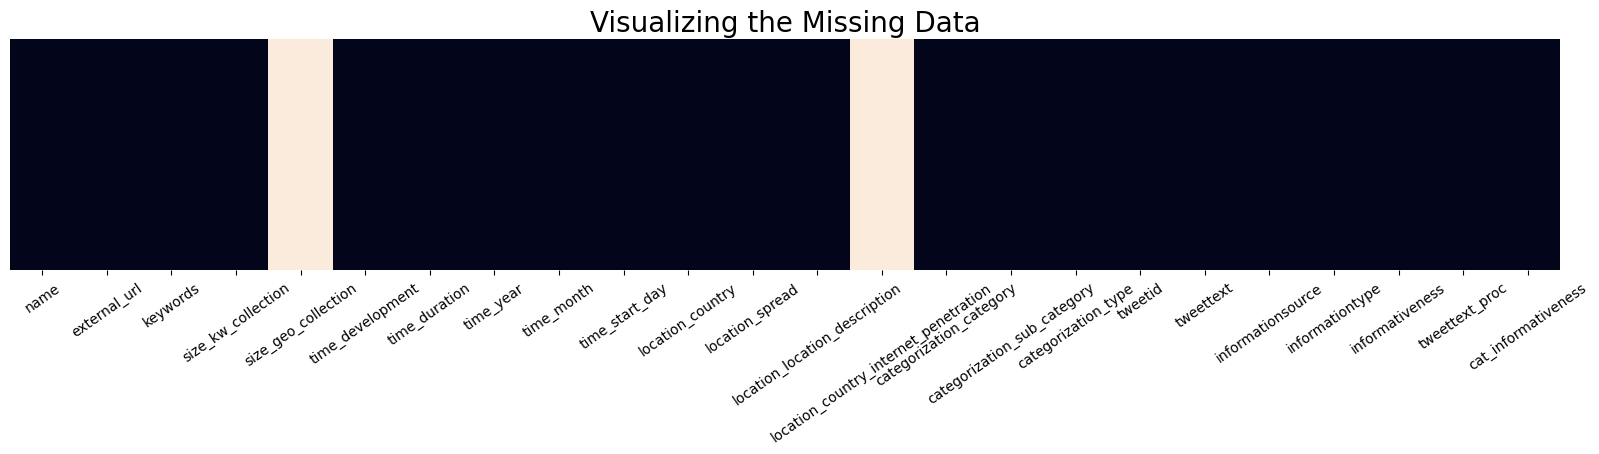

In [ ]:
plt.figure(figsize = (20, 3))
sn.heatmap(df_total.isna(), yticklabels = False, cbar = False)
plt.title("Visualizing the Missing Data", fontsize = 20)
plt.xticks(rotation = 35, fontsize = 10)
plt.show()

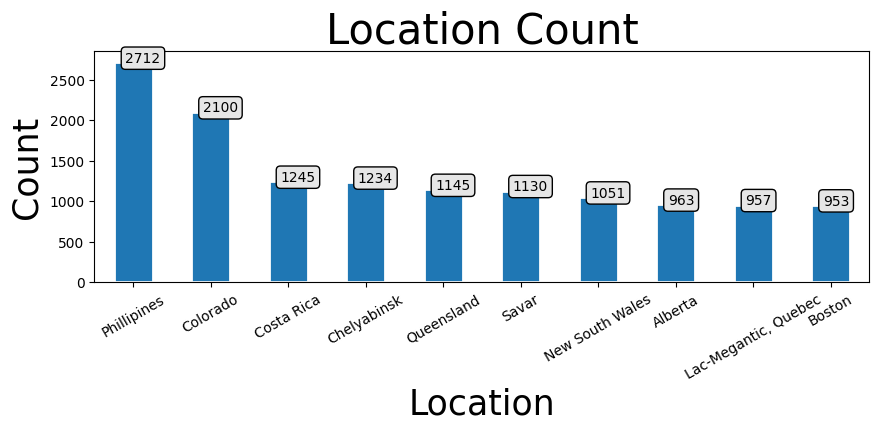

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.axes()
ax = ((df_total['location_location_description'].value_counts())[:10]).plot(kind = 'bar',  linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 30)
plt.xlabel('Location', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
ax.xaxis.set_tick_params(labelsize = 10, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 10)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 2),
                   bbox = bbox_args,
                   fontsize = 10)

## Разбиение на train и test

In [ ]:
crisis_for_test = ['Spain train crash', 'Italy earthquakes', 'Queensland Floods', 'Sardinia Floods']
df_test = df_total[df_total['name'].isin(crisis_for_test)]
df_train = df_total[~df_total['name'].isin(crisis_for_test)]
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_test.to_csv('test_data.csv' , index=False, sep = 't')
df_train.to_csv('train_data.csv', index=False, sep = 't')

## Базовая модель: фильтрация по признакам

В качестве простого бейзлайна используем фильтрацию по признакам/лексиконам: считаем твит «связанный и информативный», если в нём встречаются термины из словаря CrisisLex (по категориям события). Подобные эвристики часто применяются на ранней стадии событий и описаны в работах по кризисной аналитике (см., например, публикации TREC/ICWSM/AAAI и др.).

In [ ]:
for dirname, _, filenames in os.walk("CrisisLexLexicon"):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        if fullpath.endswith('.txt'):
            list_crisislex = open(fullpath,'r').read().splitlines()
            break

In [ ]:
def baseline_model(list_crisislex, df_total):
    pattern = '|'.join(list_crisislex)
    y_pred = df_total['tweettext_proc'].str.contains(pattern)
    return y_pred

In [ ]:
def evaluate(y_test, y_pred, trhold):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)

    y_pred  = np.where(y_pred > trhold, 1, 0)
    labels = ['Not informative', 'Related and informative']
    confusion = confusion_matrix(y_test, y_pred)


    df_cm = pd.DataFrame(confusion, index=[i for i in labels],
                         columns=[i for i in labels])

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)


    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)
    return accuracy, precision, recall, f1score, mauc


In [ ]:
for cat in df_test.categorization_type.unique():
    print(cat)
    tmp = df_test[df_test['categorization_type'] == cat]
    y_pred = baseline_model(list_crisislex, tmp)
    y_actual  = np.where(tmp.cat_informativeness =='Related and informative', True, False)
    accuracy, precision, recall, f1score, mauc = evaluate(y_actual, y_pred, 0.5)

Earthquake
                         precision    recall  f1-score   support

        Not informative       0.45      0.83      0.59       340
Related and informative       0.81      0.41      0.55       581

               accuracy                           0.57       921
              macro avg       0.63      0.62      0.57       921
           weighted avg       0.68      0.57      0.56       921

Floods
                         precision    recall  f1-score   support

        Not informative       0.55      0.72      0.62       804
Related and informative       0.77      0.61      0.68      1215

               accuracy                           0.65      2019
              macro avg       0.66      0.67      0.65      2019
           weighted avg       0.68      0.65      0.66      2019

Derailment
                         precision    recall  f1-score   support

        Not informative       0.24      0.57      0.34       181
Related and informative       0.80      0.49      0.61

Подход на основе фильтрации/ключевых слов легко пропускает сообщения, которые не содержат явных терминов, и быстро деградирует, когда меняется контекст или фокус внимания во время события. Поэтому далее мы переходим к обучаемым моделям и сравниваем их с этим базовым уровнем.